---
TDM
---
---

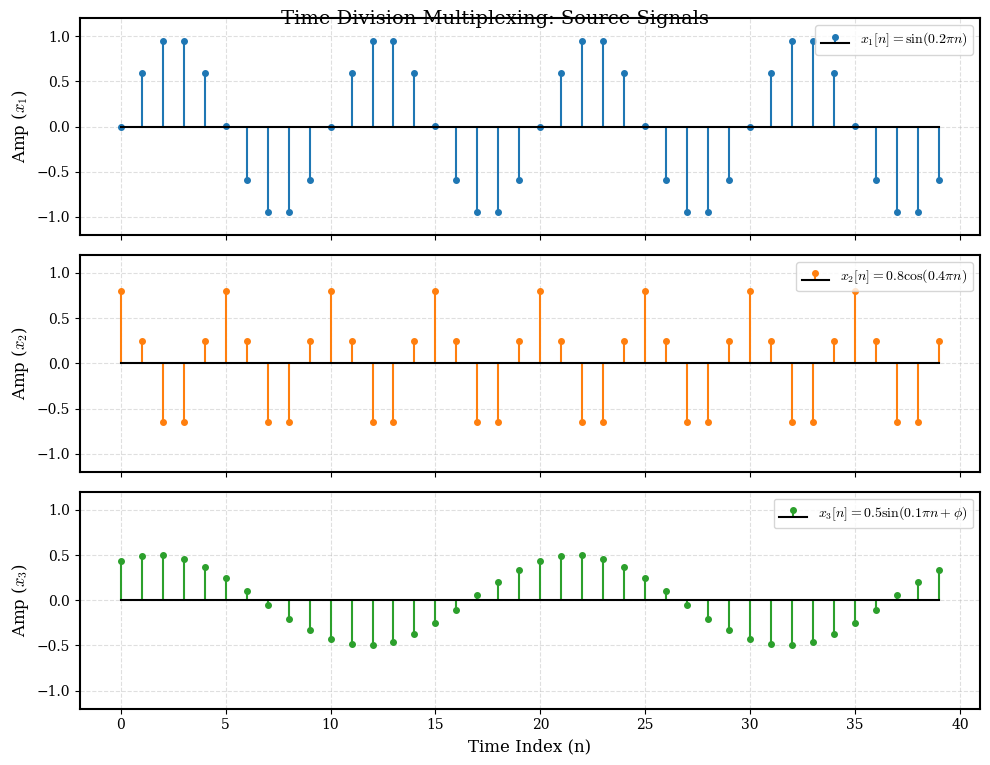

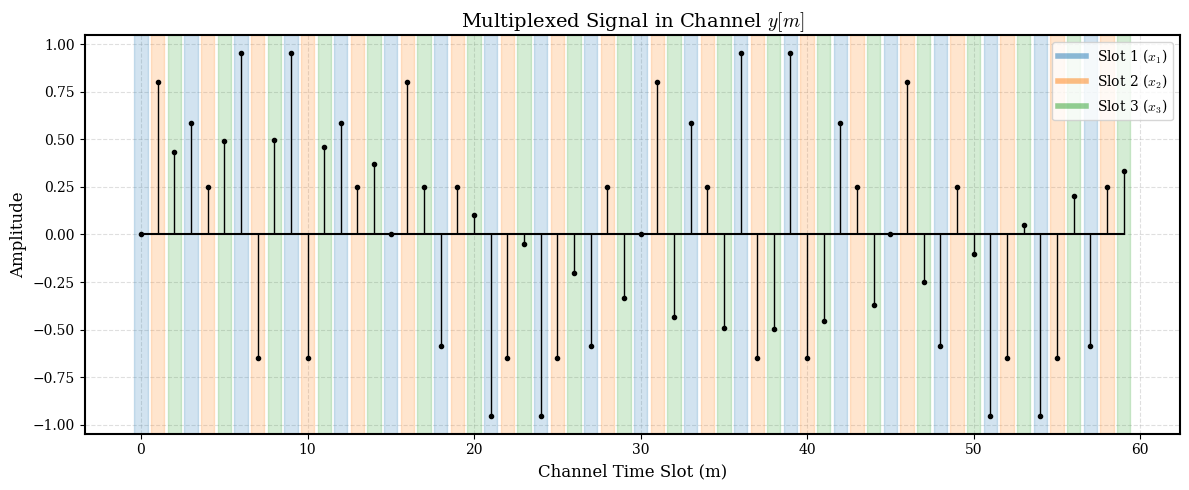

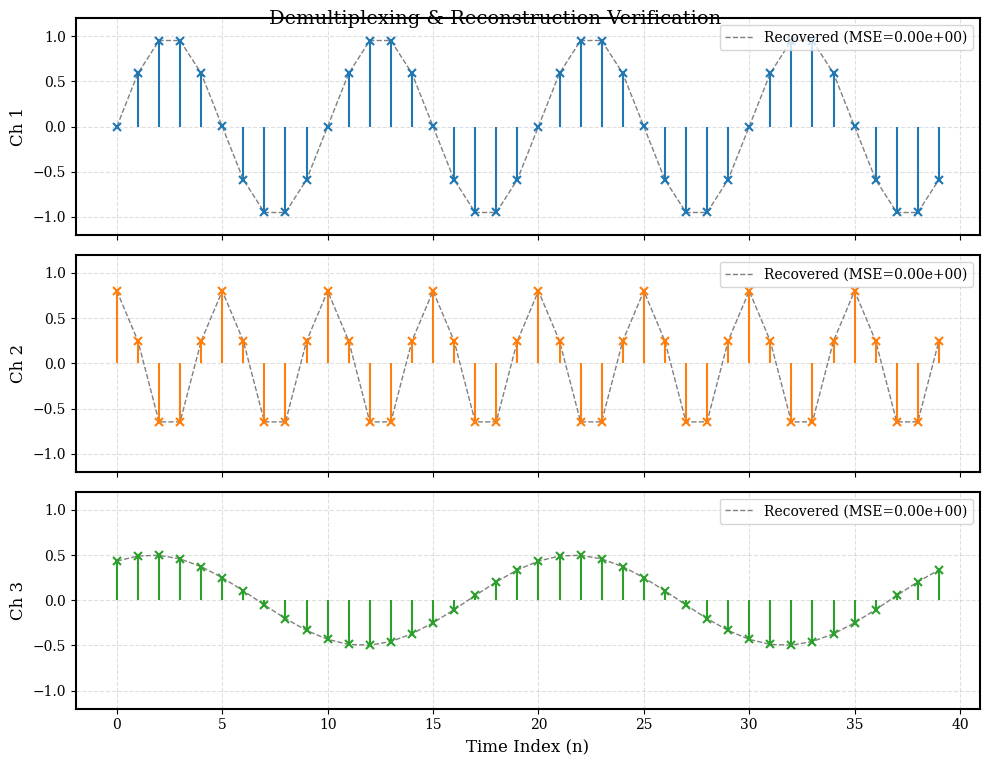

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.4
plt.rcParams['axes.axisbelow'] = True

def generate_signals(n):
    x1 = np.sin(2 * np.pi * 0.1 * n)
    x2 = 0.8 * np.cos(2 * np.pi * 0.2 * n)
    x3 = 0.5 * np.sin(2 * np.pi * 0.05 * n + np.pi/3)
    return x1, x2, x3

def multiplex(x1, x2, x3):
    N = len(x1)
    y = np.zeros(3 * N)
    
    y[0::3] = x1
    y[1::3] = x2
    y[2::3] = x3
    
    return y

def demultiplex(y):
    x1_r = y[0::3]
    x2_r = y[1::3]
    x3_r = y[2::3]
    return x1_r, x2_r, x3_r

def plot_sources(n, x1, x2, x3):
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(r'Time Division Multiplexing: Source Signals', fontsize=14, y=0.95)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    labels = [r'$x_1[n] = \sin(0.2\pi n)$', 
              r'$x_2[n] = 0.8\cos(0.4\pi n)$', 
              r'$x_3[n] = 0.5\sin(0.1\pi n + \phi)$']

    signals = [x1, x2, x3]

    for i, ax in enumerate(axes):
        markerline, stemlines, baseline = ax.stem(n, signals[i], linefmt=colors[i], basefmt='k-')
        plt.setp(markerline, marker='o', markersize=4, markerfacecolor=colors[i], markeredgecolor=colors[i])
        plt.setp(stemlines, linewidth=1.5)
        ax.set_ylabel(f'Amp ($x_{i+1}$)')
        ax.legend([labels[i]], loc='upper right', frameon=True)
        ax.set_ylim(-1.2, 1.2)

    axes[-1].set_xlabel('Time Index (n)')
    plt.tight_layout()
    plt.show()

def plot_channel(y):
    fig, ax = plt.subplots(figsize=(12, 5))
    m = np.arange(60) 
    
    markerline, stemlines, baseline = ax.stem(m, y[:60], linefmt='k-', basefmt='k-')
    plt.setp(markerline, marker='o', markersize=3, color='k')
    plt.setp(stemlines, linewidth=1)
    
    ax.set_title(r'Multiplexed Signal in Channel $y[m]$', fontsize=14)
    ax.set_xlabel('Channel Time Slot (m)')
    ax.set_ylabel('Amplitude')
    
    for i in range(0, 60, 3):
        ax.axvspan(i-0.4, i+0.4, color='#1f77b4', alpha=0.2) 
        ax.axvspan(i+0.6, i+1.4, color='#ff7f0e', alpha=0.2) 
        ax.axvspan(i+1.6, i+2.4, color='#2ca02c', alpha=0.2) 

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='#1f77b4', lw=4, alpha=0.5),
                    Line2D([0], [0], color='#ff7f0e', lw=4, alpha=0.5),
                    Line2D([0], [0], color='#2ca02c', lw=4, alpha=0.5)]
    ax.legend(custom_lines, [r'Slot 1 ($x_1$)', r'Slot 2 ($x_2$)', r'Slot 3 ($x_3$)'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

def plot_recovery(n, x_orig, x_rec):
    x1, x2, x3 = x_orig
    r1, r2, r3 = x_rec
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(r'Demultiplexing & Reconstruction Verification', fontsize=14, y=0.95)
    
    data = [(x1, r1, '#1f77b4', 'Ch 1'), (x2, r2, '#ff7f0e', 'Ch 2'), (x3, r3, '#2ca02c', 'Ch 3')]
    
    for i, (orig, rec, col, name) in enumerate(data):
        axes[i].plot(n, orig, color='gray', linestyle='--', linewidth=1, label='Original')
        markerline, stemlines, _ = axes[i].stem(n, rec, linefmt=col, basefmt=' ')
        plt.setp(markerline, marker='x', markersize=6, markeredgewidth=1.5, color=col)
        plt.setp(stemlines, linewidth=1.5)
        
        mse = np.mean((orig - rec)**2)
        axes[i].set_ylabel(name)
        axes[i].legend([f'Recovered (MSE={mse:.2e})'], loc='upper right')
        axes[i].set_ylim(-1.2, 1.2)

    axes[-1].set_xlabel('Time Index (n)')
    plt.tight_layout()
    plt.show()

def main():
    N = 40
    n = np.arange(N)
    
    x1, x2, x3 = generate_signals(n)
    y = multiplex(x1, x2, x3)
    rec_signals = demultiplex(y)
    
    plot_sources(n, x1, x2, x3)
    plot_channel(y)
    plot_recovery(n, (x1, x2, x3), rec_signals)

if __name__ == "__main__":
    main()

---
FDM
---
---

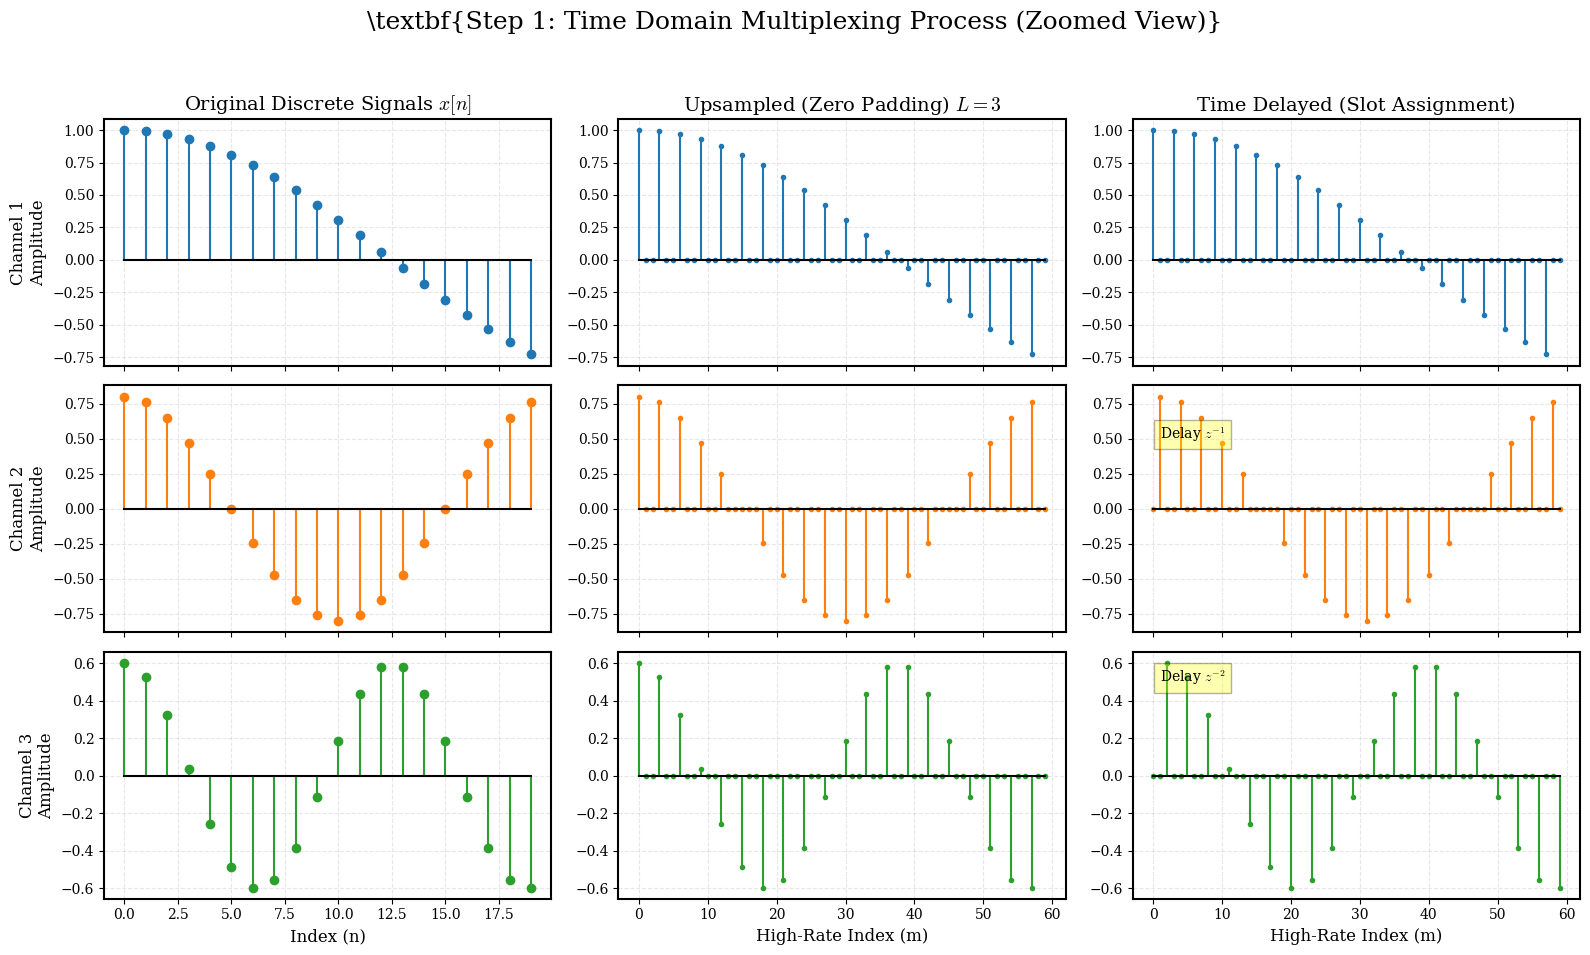

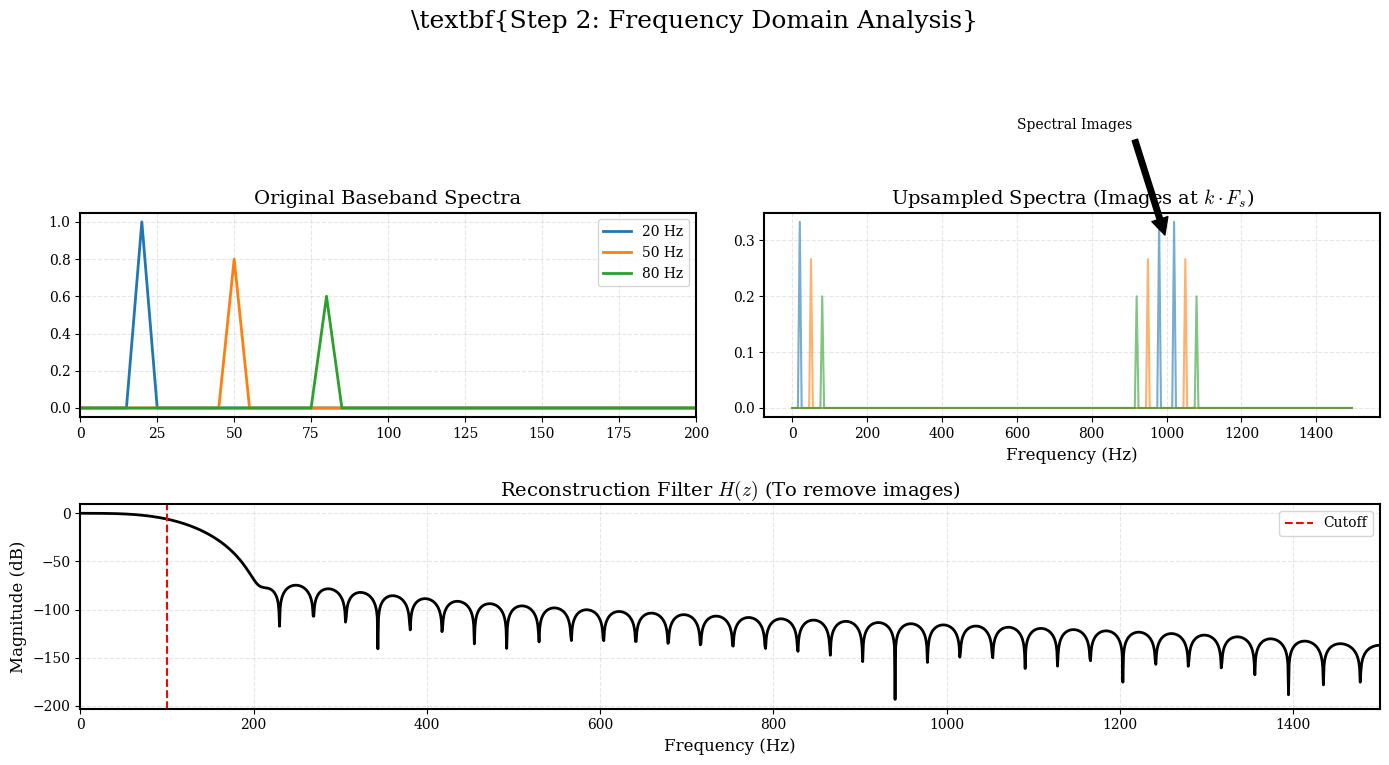

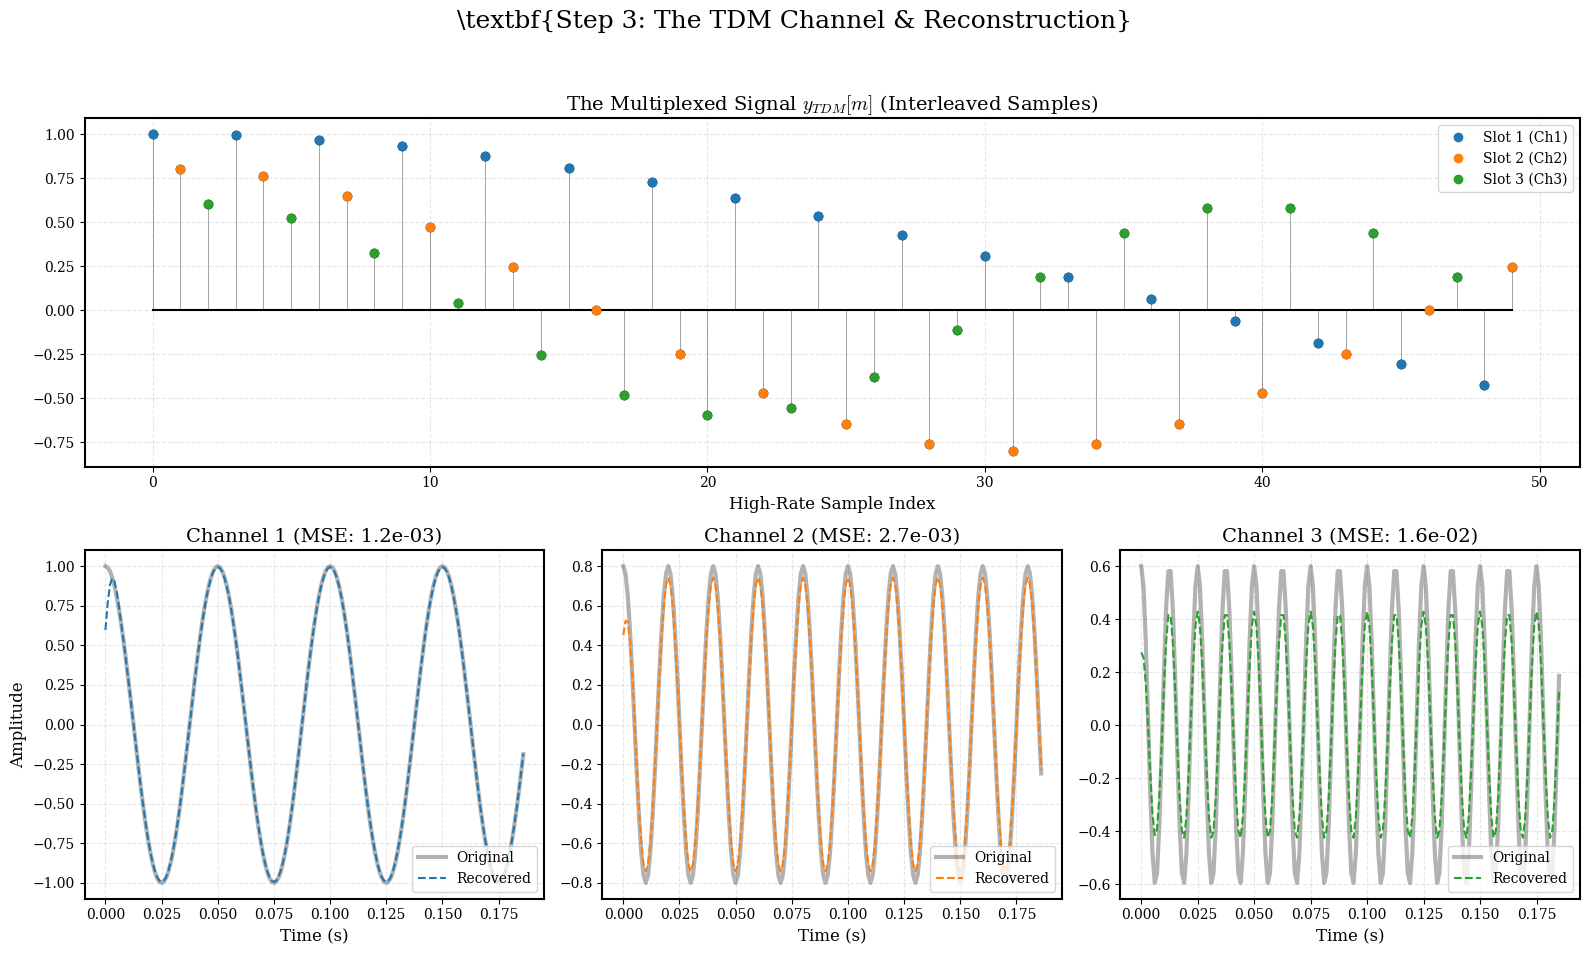

In [18]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Academic Plotting Configuration
# -----------------------------------------------------------------------------
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm' # Computer Modern (TeX-like)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# -----------------------------------------------------------------------------
# 2. System Parameters
# -----------------------------------------------------------------------------
class SystemConfig:
    Fs = 1000.0             # Base Sampling Rate (Hz)
    Duration = 0.2          # Short duration for better visualization
    L = 3                   # Multiplexing Factor (3 Channels)
    Freqs = [20, 50, 80]    # Signal Frequencies
    
    # Reconstruction Filter
    Cutoff = 100.0          # Cutoff Hz
    FilterOrder = 80        

# -----------------------------------------------------------------------------
# 3. DSP Functions
# -----------------------------------------------------------------------------
def get_spectrum(x, fs):
    N = len(x)
    X = fftpack.fft(x)
    freqs = fftpack.fftfreq(N, d=1/fs)
    mask = freqs >= 0
    return freqs[mask], 2.0/N * np.abs(X)[mask]

def design_filter(fs_high):
    nyq = 0.5 * fs_high
    b = signal.firwin(SystemConfig.FilterOrder + 1, 
                      SystemConfig.Cutoff / nyq, 
                      window='blackman')
    return b

def compensate_delay(y, b):
    delay = int((len(b)-1)/2)
    return y[delay:]

def generate_signals():
    N = int(SystemConfig.Fs * SystemConfig.Duration)
    t = np.arange(N) / SystemConfig.Fs
    x1 = np.cos(2 * np.pi * SystemConfig.Freqs[0] * t)
    x2 = 0.8 * np.cos(2 * np.pi * SystemConfig.Freqs[1] * t)
    x3 = 0.6 * np.cos(2 * np.pi * SystemConfig.Freqs[2] * t)
    return t, [x1, x2, x3]

# -----------------------------------------------------------------------------
# 4. Processing Steps
# -----------------------------------------------------------------------------
def run_tdm_simulation():
    # A. Source Generation
    t, sources = generate_signals()
    
    # B. Upsampling (Step 1 of TDM)
    upsampled = []
    for x in sources:
        x_up = np.zeros(len(x) * SystemConfig.L)
        x_up[::SystemConfig.L] = x
        upsampled.append(x_up)
    
    # C. Delay & Multiplexing (Step 2 & 3)
    # Slot 0: x1_up (No delay)
    # Slot 1: x2_up (Delay 1)
    # Slot 2: x3_up (Delay 2)
    
    delayed_signals = []
    # Ch 1
    delayed_signals.append(upsampled[0])
    
    # Ch 2
    d1 = np.roll(upsampled[1], 1); d1[0] = 0
    delayed_signals.append(d1)
    
    # Ch 3
    d2 = np.roll(upsampled[2], 2); d2[:2] = 0
    delayed_signals.append(d2)
    
    # Combine
    y_tdm = sum(delayed_signals)
    
    # D. Demultiplexing & Reconstruction
    fs_high = SystemConfig.Fs * SystemConfig.L
    b_filter = design_filter(fs_high)
    recovered = []
    
    # Logic: Extract Slot -> Filter (Interpolate) -> Decimate
    for i in range(SystemConfig.L):
        # 1. Extraction (Time Gating)
        extracted = np.zeros_like(y_tdm)
        extracted[i::SystemConfig.L] = y_tdm[i::SystemConfig.L]
        
        # 2. Filtering
        filtered = signal.lfilter(b_filter, 1.0, extracted)
        filtered = compensate_delay(filtered, b_filter)
        
        # 3. Decimation (Downsampling)
        rec = filtered[i::SystemConfig.L]
        
        # Synchronization & Gain Fix
        min_len = min(len(sources[i]), len(rec))
        rec = rec[:min_len] * SystemConfig.L # Gain correction for interpolation
        recovered.append(rec)

    return t, sources, upsampled, delayed_signals, y_tdm, recovered, b_filter

# -----------------------------------------------------------------------------
# 5. Visualization (The Academic Part)
# -----------------------------------------------------------------------------
def plot_results(data):
    t, sources, upsampled, delayed, y_tdm, recovered, b_filter = data
    
    # =========================================================================
    # Figure 1: Time Domain Logic (Zoomed In)
    # Purpose: Show how samples are spaced and interleaved
    # =========================================================================
    fig1, ax1 = plt.subplots(3, 3, figsize=(16, 10), sharex='col')
    fig1.suptitle(r'\textbf{Step 1: Time Domain Multiplexing Process (Zoomed View)}', fontsize=18)
    
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    labels = ['Channel 1', 'Channel 2', 'Channel 3']
    
    # Limit samples to show detail
    zoom_samples = 20 
    
    for i in range(3):
        # Col 1: Original
        ax1[i, 0].stem(sources[i][:zoom_samples], linefmt=colors[i], basefmt='k-', markerfmt='o')
        ax1[i, 0].set_ylabel(f'{labels[i]}\nAmplitude')
        if i == 0: ax1[i, 0].set_title(r'Original Discrete Signals $x[n]$')
        
        # Col 2: Upsampled (Zeros inserted)
        ax1[i, 1].stem(upsampled[i][:zoom_samples*3], linefmt=colors[i], basefmt='k-', markerfmt='.')
        if i == 0: ax1[i, 1].set_title(r'Upsampled (Zero Padding) $L=3$')
        
        # Col 3: Delayed (Positioning in Slots)
        ax1[i, 2].stem(delayed[i][:zoom_samples*3], linefmt=colors[i], basefmt='k-', markerfmt='.')
        if i == 0: ax1[i, 2].set_title(r'Time Delayed (Slot Assignment)')
        
        # Add visual delay indicator text
        if i > 0:
            ax1[i, 2].text(1, 0.5, f'Delay $z^{{-{i}}}$', fontsize=10, 
                          bbox=dict(facecolor='yellow', alpha=0.3))

    ax1[2, 0].set_xlabel('Index (n)')
    ax1[2, 1].set_xlabel('High-Rate Index (m)')
    ax1[2, 2].set_xlabel('High-Rate Index (m)')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # =========================================================================
    # Figure 2: Spectral Analysis
    # Purpose: Show Aliasing/Imaging and Filtering
    # =========================================================================
    fig2 = plt.figure(figsize=(14, 8))
    fig2.suptitle(r'\textbf{Step 2: Frequency Domain Analysis}', fontsize=18)
    
    # 2.1 Baseband Spectra
    ax2_1 = fig2.add_subplot(2, 2, 1)
    for i, s in enumerate(sources):
        f, m = get_spectrum(s, SystemConfig.Fs)
        ax2_1.plot(f, m, color=colors[i], lw=2, label=f'{SystemConfig.Freqs[i]} Hz')
    ax2_1.set_title(r'Original Baseband Spectra')
    ax2_1.set_xlim(0, 200)
    ax2_1.legend()
    
    # 2.2 Upsampled Spectra (Imaging)
    ax2_2 = fig2.add_subplot(2, 2, 2)
    fs_high = SystemConfig.Fs * SystemConfig.L
    for i, s in enumerate(upsampled):
        f, m = get_spectrum(s, fs_high)
        ax2_2.plot(f, m, color=colors[i], alpha=0.6)
    ax2_2.set_title(r'Upsampled Spectra (Images at $k \cdot F_s$)')
    ax2_2.set_xlabel('Frequency (Hz)')
    ax2_2.annotate('Spectral Images', xy=(1000, 0.3), xytext=(600, 0.5),
                   arrowprops=dict(facecolor='black', shrink=0.05))
    
    # 2.3 Filter Response
    ax2_3 = fig2.add_subplot(2, 1, 2)
    w, h = signal.freqz(b_filter, worN=2048, fs=fs_high)
    ax2_3.plot(w, 20 * np.log10(abs(h)), 'k', lw=2)
    ax2_3.set_title(r'Reconstruction Filter $H(z)$ (To remove images)')
    ax2_3.set_ylabel('Magnitude (dB)')
    ax2_3.set_xlabel('Frequency (Hz)')
    ax2_3.set_xlim(0, fs_high/2)
    ax2_3.grid(True, which='both')
    ax2_3.axvline(SystemConfig.Cutoff, color='r', linestyle='--', label='Cutoff')
    ax2_3.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # =========================================================================
    # Figure 3: Channel View & Reconstruction
    # Purpose: Show the interleaved signal and final result
    # =========================================================================
    fig3 = plt.figure(figsize=(16, 10))
    fig3.suptitle(r'\textbf{Step 3: The TDM Channel & Reconstruction}', fontsize=18)
    
    # 3.1 The Multiplexed Signal (Zoomed)
    ax3_1 = fig3.add_subplot(2, 1, 1)
    # Plot stems for each component to show interleaving
    m = np.arange(len(y_tdm))
    zoom = 50
    
    markerline, stemlines, baseline = ax3_1.stem(m[:zoom], y_tdm[:zoom], 
                                                linefmt='k-', markerfmt='ko', basefmt='k-')
    plt.setp(stemlines, 'linewidth', 0.5, 'alpha', 0.5)
    
    # Overlay colored dots to show ownership
    ax3_1.plot(m[:zoom:3], y_tdm[:zoom:3], 'o', color=colors[0], label='Slot 1 (Ch1)')
    ax3_1.plot(m[1:zoom:3], y_tdm[1:zoom:3], 'o', color=colors[1], label='Slot 2 (Ch2)')
    ax3_1.plot(m[2:zoom:3], y_tdm[2:zoom:3], 'o', color=colors[2], label='Slot 3 (Ch3)')
    
    ax3_1.set_title(r'The Multiplexed Signal $y_{TDM}[m]$ (Interleaved Samples)')
    ax3_1.legend(loc='upper right')
    ax3_1.set_xlabel('High-Rate Sample Index')
    
    # 3.2 Comparison
    for i in range(3):
        ax = fig3.add_subplot(2, 3, i + 4)
        
        # Calculate MSE
        min_len = min(len(sources[i]), len(recovered[i]))
        orig = sources[i][:min_len]
        rec = recovered[i][:min_len]
        mse = np.mean((orig - rec)**2)
        
        ax.plot(t[:min_len], orig, 'k-', lw=3, alpha=0.3, label='Original')
        ax.plot(t[:min_len], rec, color=colors[i], ls='--', label='Recovered')
        
        ax.set_title(f'Channel {i+1} (MSE: {mse:.1e})')
        ax.set_xlabel('Time (s)')
        ax.grid(True)
        if i == 0: ax.set_ylabel('Amplitude')
        ax.legend(loc='lower right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

# -----------------------------------------------------------------------------
# Main Execution
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    data = run_tdm_simulation()
    plot_results(data)